### RNNLM 구현

In [ ]:
import numpy as np
xs = np.array([[1,2,3]])
print(xs.shape)
print(xs[:,0])
print(xs[:,0].shape)
W = np.arange(28).reshape(7,4)
print(W[0])
print(W[[0]])

In [ ]:
a = np.array([1,2,3])
a = a.reshape(-1,1)
print(a)

In [ ]:
a = np.array([1,2,3])
a = a[:, np.newaxis]
print(a)

In [ ]:
a = np.array([1,2,3])
a = a[np.newaxis, :]
print(a)

In [ ]:
a = np.array([[1,2],
              [3,4]])
# b = 3
# b = np.array([2,2])
b = np.array([[2],[2]])
a+b   # (2,2) + (2,1) => (2,2) + (2,2)

In [ ]:
import numpy as np
dx = np.arange(21).reshape(3,7)
mask = np.ones((3,))
print(mask)
print(mask.shape)
print(mask.reshape(3,1).shape)
print(mask[:, np.newaxis].shape)

dx * mask[:, np.newaxis]  # (3,7)*(3,1) => (3,7)*(3,7)

In [ ]:
import sys
sys.path.append('..')
import numpy as np
from common.time_layers import *

D=4
H=3
rnn_Wx = np.arange(D*H).reshape(D,H)
rnn_Wh = np.arange(H*H).reshape(H,H)
rnn_b = np.arange(H)

rnn = RNN(rnn_Wx, rnn_Wh, rnn_b)
print(rnn.params[0])
print(rnn.params[1])
print(rnn.params[2])

In [ ]:
a = (1,2)
print(type(a))
b = 1,2
print(type(b))
a,b = (1,2)
print(type(a))

def foo():
    return 1,2

a,b = foo()
print(a,b)

def foo(a,b):
    print(a,b)
    
foo(*(1,2))


a = np.arange(3*4).reshape(3,4)
b = np.random.rand(*a.shape) # 명시적인 튜플 언패킹
print(a)
print(b)

In [ ]:
class AAA:
    def __init__(self):
        self.x = 10
        y = 20
        print('__init__()', self)
        
    def foo(self):
        print(self.x)
#         print(y)
        
a = AAA()
print(a)
a.foo()

In [ ]:
def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x

xs = np.random.randn(3,7)
ts = np.array([1,2,3])
ys = softmax(xs)
print(ys)
print(np.sum(ys, axis=1))

print(ys[np.arange(1 * 3), ts])
ls = np.log(ys[np.arange(1 * 3), ts])
print(ls)
loss = -np.sum(ls)
print(loss)
loss /= 3
print(loss)

In [ ]:
mask = np.array([1,1,1])
print(mask)
print(mask.shape)
print(mask.reshape(-1,1).shape)
print(mask[:, np.newaxis].shape)
print(mask[:, np.newaxis])

In [ ]:
dx = np.arange(21).reshape(3,7)
print(dx)
mask = np.array([0,1,0])
dx *= mask[:, np.newaxis]
print(dx)

In [ ]:
for i in reversed(range(3)):
    print(i)

In [1]:
import sys
sys.path.append('..')
import numpy as np
from common.time_layers import *


class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 가중치 초기화
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # 계층 생성
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        # 모든 가중치와 기울기를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()

### RNNLM의 학습 코드

In [12]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb
from simple_rnnlm import SimpleRnnlm

corpus, word_to_id, id_to_word = ptb.load_data('train')
print(corpus.shape)
print(corpus[:100])
print(type(word_to_id))
print(len(word_to_id))
print(id_to_word[26])

for i in range(100):
    print(id_to_word[corpus[i]], end=' ')
print()

print(word_to_id['centrust'])

vocab_size = int(max(corpus) + 1)
print('말뭉치 크기: %d, 어휘 수: %d' % (len(corpus), vocab_size))
print(len(word_to_id))

(929589,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 27 24 39 26 40 41 42 26 43
 32 44 45 46 24 47 26 27 28 29 48 49 41 42 50 51 52 53 54 55 35 36 37 42
 56 57 58 59 24 35 60 42 61 62 63 64 65 66 67 68 69 70 35 71 72 42 73 74
 75 35 46 42]
<class 'dict'>
10000
<unk>
aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter <eos> pierre <unk> N years old will join the board as a nonexecutive director nov. N <eos> mr. <unk> is chairman of <unk> n.v. the dutch publishing group <eos> rudolph <unk> N years old and former chairman of consolidated gold fields plc was named a nonexecutive director of this british industrial conglomerate <eos> a form of asbestos once used to make kent cigarette filters has caused a high percentage of cancer deaths among a group of 
4
말뭉치 크기: 929589, 어휘 수: 10000
10000


| 에폭 1 | 퍼플렉서티 381.20
| 에폭 2 | 퍼플렉서티 253.18
| 에폭 3 | 퍼플렉서티 221.54
| 에폭 4 | 퍼플렉서티 213.72
| 에폭 5 | 퍼플렉서티 204.30
| 에폭 6 | 퍼플렉서티 201.27
| 에폭 7 | 퍼플렉서티 197.19
| 에폭 8 | 퍼플렉서티 195.92
| 에폭 9 | 퍼플렉서티 190.93
| 에폭 10 | 퍼플렉서티 192.85
| 에폭 11 | 퍼플렉서티 189.02
| 에폭 12 | 퍼플렉서티 192.22
| 에폭 13 | 퍼플렉서티 190.68
| 에폭 14 | 퍼플렉서티 191.20
| 에폭 15 | 퍼플렉서티 190.42
| 에폭 16 | 퍼플렉서티 186.12
| 에폭 17 | 퍼플렉서티 184.48
| 에폭 18 | 퍼플렉서티 181.32
| 에폭 19 | 퍼플렉서티 182.51
| 에폭 20 | 퍼플렉서티 182.95
| 에폭 21 | 퍼플렉서티 181.28
| 에폭 22 | 퍼플렉서티 177.17
| 에폭 23 | 퍼플렉서티 174.91
| 에폭 24 | 퍼플렉서티 175.54
| 에폭 25 | 퍼플렉서티 173.16
| 에폭 26 | 퍼플렉서티 172.82
| 에폭 27 | 퍼플렉서티 167.53
| 에폭 28 | 퍼플렉서티 166.15
| 에폭 29 | 퍼플렉서티 164.06
| 에폭 30 | 퍼플렉서티 157.03
| 에폭 31 | 퍼플렉서티 157.72
| 에폭 32 | 퍼플렉서티 152.77
| 에폭 33 | 퍼플렉서티 153.17
| 에폭 34 | 퍼플렉서티 146.34
| 에폭 35 | 퍼플렉서티 145.01
| 에폭 36 | 퍼플렉서티 139.85
| 에폭 37 | 퍼플렉서티 136.53
| 에폭 38 | 퍼플렉서티 134.42
| 에폭 39 | 퍼플렉서티 127.24
| 에폭 40 | 퍼플렉서티 121.77
| 에폭 41 | 퍼플렉서티 122.39
| 에폭 42 | 퍼플렉서티 115.57
| 에폭 43 | 퍼플렉서티 109.36
| 에폭 44 | 퍼플렉서티 105.

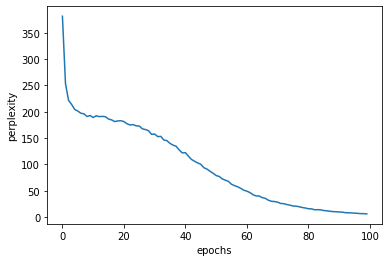

In [15]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb
from simple_rnnlm import SimpleRnnlm


# 1. (N,T) 로 입력
# 2. (N,T) => (N,T,D)  임베딩층 통과 시
# 3. (N,H)(H,H)+(N,D)(D,H)+(H,) => (N,H) => (N,T,H)  RNN 층 통과 시

# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100 # RNN의 은닉 상태 벡터의 원소 수
time_size = 5     # Truncated BPTT가 한 번에 펼치는 시간 크기
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기(전체 중 1000개만)
corpus, word_to_id, id_to_word = ptb.load_data('train')
# print('말뭉치 크기: %d, 어휘 수: %d' % (corpus_size, vocab_size))
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)
# print(vocab_size)

xs = corpus[:-1]  # 입력
ts = corpus[1:]   # 출력(정답 레이블)
data_size = len(xs)
# print('말뭉치 크기: %d, 어휘 수: %d' % (corpus_size, vocab_size))

# 학습 시 사용하는 변수
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# 미니배치의 각 샘플의 읽기 시작 위치를 계산
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # 미니배치 취득
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 기울기를 구하여 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # 에폭마다 퍼플렉서티 평가
    ppl = np.exp(total_loss / loss_count)
    print('| 에폭 %d | 퍼플렉서티 %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

# 그래프 그리기
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()


In [ ]:
model.layers[0].W[1]

### RNNLM의 Trainer 클래스

In [ ]:
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from dataset import ptb
from simple_rnnlm import SimpleRnnlm
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic')

# 하이퍼파라미터 설정
batch_size = 10
wordvec_size = 100
hidden_size = 100  # RNN의 은닉 상태 벡터의 원소 수
time_size = 5  # RNN을 펼치는 크기
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000  # 테스트 데이터셋을 작게 설정
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)
xs = corpus[:-1]  # 입력
ts = corpus[1:]  # 출력（정답 레이블）

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size)
trainer.plot()


In [ ]:
import numpy as np

out = np.zeros((2,3,4))
embed_W = np.arange(28).reshape(7,4)

idx = [0,3]
out[:,0,:] = embed_W[idx]
idx = [1,4]
out[:,1,:] = embed_W[idx]
idx = [2,1]
out[:,2,:] = embed_W[idx]

out



In [ ]:
import numpy as np

xs = np.arange(18).reshape(2,3,3)
print(xs)
rx  = xs.reshape(2*3,-1)
print(rx)